# Stock price prediction

## Key assumptions as mentioned in the form
1. **Primary influence**:
Stock price movement is primarily influenced by the change in data from the previous day.
2. **Other factors**:
While additional variables may influence stock prices in real-world scenarios, they should be ignored for the purpose of this assignment.

## Project objective
Develop a python-based machine learning model to predict stock prices using the values from the Data dataset.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Basic styling
plt.style.use('ggplot')

# Sanity check to see if there were any problems during importing
print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Loading and Cleaning the data
First, we load the datasets and merge them by `Date`. We ensure the data is sorted chronologically to avoid *Data leakage* in our training, which will render it useless for actual real-world prediction.

In [22]:
# Load datasets
data_df = pd.read_csv('../data/Data.csv')
stock_df = pd.read_csv('../data/StockPrice.csv')

# Convert dates, by default python interprets it as string
data_df['Date'] = pd.to_datetime(data_df['Date'])
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Sort by date
data_df = data_df.sort_values('Date')
stock_df = stock_df.sort_values('Date')

# Check shapes
print(f"Data rows: {data_df.shape[0]}")
print(f"Stock rows: {stock_df.shape[0]}")
print(f"Difference: {data_df.shape[0] - stock_df.shape[0]} rows")

# If we just check the numer of lines in both the .csv files, we can identify a mismatch of 63 lines, which has to be handled else we might incur wierd behaviour later on
data_dates = set(data_df['Date'])
stock_dates = set(stock_df['Date'])
only_in_data = data_dates - stock_dates
only_in_stock = stock_dates -data_dates

print(f"\nDates in Data.csv but missing in StockPrice.csv: {len(only_in_data)}")
print(f"Dates in StockPrice.csv but missing in Data.csv: {len(only_in_stock)}")
print(f"Example Missing Dates: {[d.date() for d in sorted(list(only_in_data))[:5]]}")

Data rows: 3902
Stock rows: 3839
Difference: 63 rows

Dates in Data.csv but missing in StockPrice.csv: 100
Dates in StockPrice.csv but missing in Data.csv: 37
Example Missing Dates: [datetime.date(2010, 1, 18), datetime.date(2010, 2, 15), datetime.date(2010, 5, 31), datetime.date(2010, 7, 5), datetime.date(2010, 9, 6)]


### Finding
We found **100 dates** (like `2010-01-18`) where we have `Data` but no `StockPrice` and **37 dates** where we have `StockPrice` but no `Data`.

This matters because stock price is influenced by the *change in data from the **previous day**.* Therefore, if a given day is a Monday (let's assume) and it's a holiday on that day, then the "previous day" for Tuesday will be **Monday**. So, if we `merge` first, Monday is deleted and the model will think the "previous day" was **Friday**, in which case we would have been feeding **incorrect data** into the model.

To fix this, we must calculate the **Data change** features *before* merging. This ensures Tuesday's row correctly remembers Monday's data, even if Monday's row is later dropped from the training set.

In [23]:
# We can't merge first as it will cause us to lose the data of days where no data is associate with StockPrice.csv
data_df['Data_Lag1'] = data_df['Data'].shift(1)
data_df['Data_Lag2'] = data_df['Data'].shift(2)
data_df['Data_Change_PrevDay'] = data_df['Data_Lag1'] - data_df['Data_Lag2']
data_df['Data_Rolling_Mean'] = data_df['Data_Lag1'].rolling(window=3).mean()

# Merging here gets rid of the days where there is no previous data associated with it.
# Example: Let's say that Monday has no stock price, so it will be deleted but it won't affect Tuesday as it is already memorized
df = pd.merge(data_df, stock_df, on='Date', how='inner')

# Calculate the actual price movement between trading days
df['Price_Change'] = df['Price'] - df['Price'].shift(1)

# Remove the first few rows that have empty values because they don't have enough past data to calculate the changes
df = df.dropna()

print(f"Final Merged & Processed Shape: {df.shape}")
df[['Date', 'Data_Lag1', 'Data_Change_PrevDay', 'Price', 'Price_Change']].head()

Final Merged & Processed Shape: (3799, 8)


,Date,Data_Lag1,Data_Change_PrevDay,Price,Price_Change
3,2010-01-07,0.694,-0.005,1186.75,4.5
4,2010-01-08,0.692,-0.002,1190.75,4.0
5,2010-01-11,0.691,-0.001,1191.75,1.0
6,2010-01-12,0.689,-0.002,1183.25,-8.5
7,2010-01-13,0.685,-0.004,1190.75,7.5


## 2. Testing the Assumption
The assignment states: *"Stock price movement is primarily influenced by the change in data from the previous day."*

We will try to verify the correlation between:
1.  **Data Change** (Today's Data - Yesterday's Data)
2.  **Price Movement** (Today's Price - Yesterday's Price)

Correlation Matrix:
                      Price_Change  Data_Change_PrevDay
Price_Change             1.000000             0.003346
Data_Change_PrevDay      0.003346             1.000000


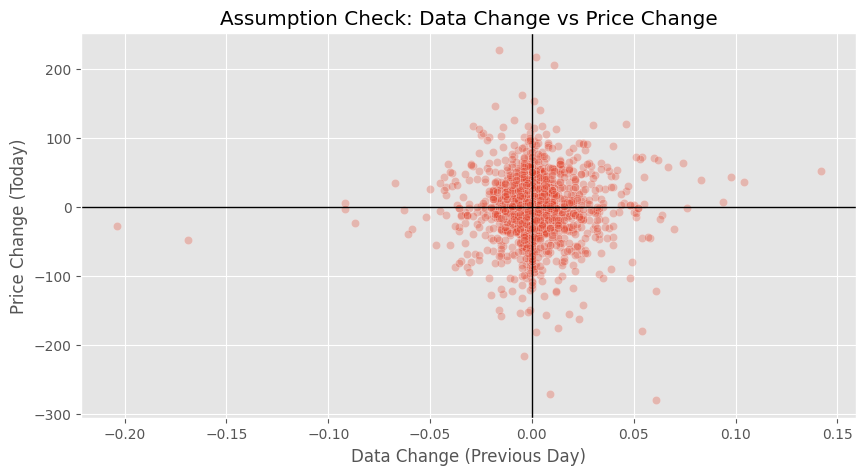

In [24]:
# Creating variables to store the 'Data' values of the previous 2 days
df['Data_Lag1'] = df['Data'].shift(1)  # -1 Day's Data
df['Data_Lag2'] = df['Data'].shift(2)  # -2 Day's Data

# Data change (t-1) vs. Price change(t), so that we can calculate the movement
df['Data_Change_PrevDay'] = df['Data_Lag1'] - df['Data_Lag2']
df['Price_Change'] = df['Price'] - df['Price'].shift(1)

# Removing the first few days as they have no previous data to compare to
df_eda = df.dropna()

# Correlation matrix
corr = df_eda[['Price_Change', 'Data_Change_PrevDay']].corr()
print("Correlation Matrix:\n", corr)

# Visualization
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_eda['Data_Change_PrevDay'], y=df_eda['Price_Change'], alpha=0.3)
plt.title('Assumption Check: Data Change vs Price Change')
plt.xlabel('Data Change (Previous Day)')
plt.ylabel('Price Change (Today)')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.show()

### Observation
The correlation is likely **very low** (near 0). The scatter plot has the data points in a condensed blob rather than a line, which confirms that the relationship is **not linear**. 

If we feed this into a simple Linear Regression model to predict the *Raw Price*, it will fail.

## 3. My Initial attempt of a Linear Regression model
Let's try to predict the **Raw Stock Price** directly using the features we have.
* **Target**: `Price`
* **Features**: `Data_Lag1`, `Data_Change_PrevDay`

LR Model R-Squared: -107.8359


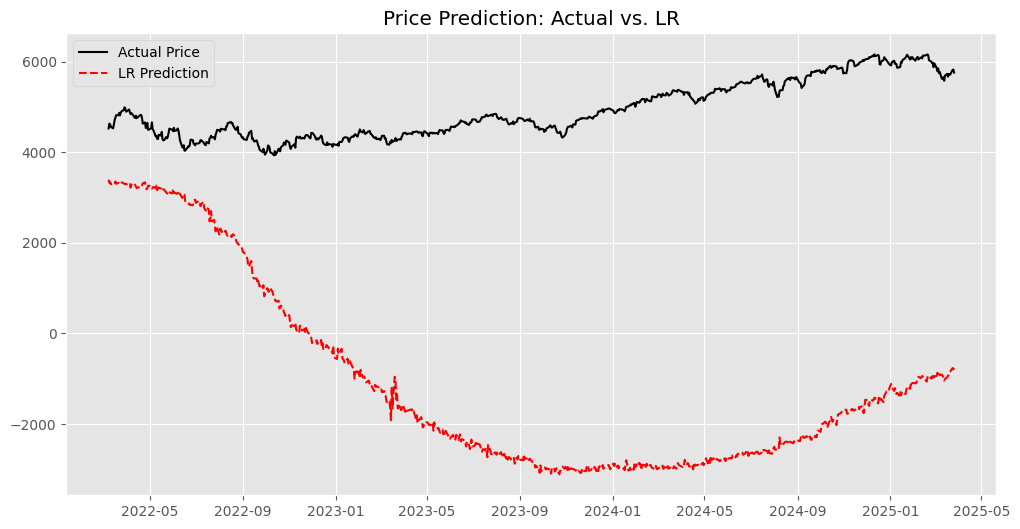

In [25]:
# Preparing Data for the Linear Regression Model
features_naive = ['Data_Lag1', 'Data_Change_PrevDay']
target_naive = 'Price'

X = df_eda[features_naive]
y = df_eda[target_naive]

# Splitting the data based on the time-stamps in a 80/20 fashion (80% for training and 20% for testing).
train_size = int(len(df_eda) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Training the Linear Regression (Baseline) model
lr = LinearRegression()
lr.fit(X_train, y_train)
preds_naive = lr.predict(X_test)

# Evaluation
r2_naive = r2_score(y_test, preds_naive)
print(f"LR Model R-Squared: {r2_naive:.4f}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_eda['Date'].iloc[train_size:], y_test, label='Actual Price', color='black')
plt.plot(df_eda['Date'].iloc[train_size:], preds_naive, label='LR Prediction', linestyle='--', color='red')
plt.title('Price Prediction: Actual vs. LR')
plt.legend()
plt.show()

As we can see from the R-squared value, the Linear Regression model fails which the visualization already predicted. Trying for a better approach.


## 4. Reason for failure
The plot above shows that the model fails to capture the trend. The reasons for it are -
1.  Stock prices drift over time. The model was trained on prices in the 1000s, but tested on prices in the 5000s. It doesn't know how to extrapolate the previous data to the new data.
2.  The "Data Change" feature is weak on its own.

### New Approach: Differencing
Instead of predicting the absolute **Price** (which creates trend errors), we can predict the **Price Change**.
$$Predicted\_Price_t = Actual\_Price_{t-1} + Predicted\_Change_t$$
This removes the trend component and allows the model to focus on the *market mechanics*.

## 5. Random Forest+Differencing attempt
We will now try the following -
1.  Target **`Price_Change`** instead of `Price`.
2.  Add a **Rolling Mean** feature to give the model context about the current trend.
3.  Use **Random Forest** to capture non-linear relationships.

In [26]:
# Adding rolling mean for context
df_eda['Data_Rolling_Mean'] = df_eda['Data_Lag1'].rolling(window=5).mean()
df_model = df_eda.dropna().copy()

# Updating the features and the target
features_final = ['Data_Lag1', 'Data_Change_PrevDay', 'Data_Rolling_Mean']
target_final = 'Price_Change'

X = df_model[features_final]
y = df_model[target_final]

# Data split into training and testing (80% and 20% respectively)
train_size = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Training the Random forest  model
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predicting the change
pred_change = rf.predict(X_test)

# Reconstructing price according to the formula stated above
# Price_(t) = Price_(t-1) + Predicted_Change
test_indices = X_test.index
previous_prices = df_model.loc[test_indices, 'Price'].shift(1)
previous_prices.iloc[0] = df_model.loc[df_model.index[train_size - 1], 'Price']

predicted_prices = previous_prices + pred_change
actual_prices = df_model.loc[test_indices, 'Price']

# Evaluating the new model
r2_final = r2_score(actual_prices, predicted_prices)
rmse_final = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

print(f"--- Final Results ---")
print(f"R-Squared: {r2_final:.4f}")
print(f"RMSE: {rmse_final:.2f}")

C:\Users\kumar\AppData\Local\Temp\ipykernel_2500\642807377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['Data_Rolling_Mean'] = df_eda['Data_Lag1'].rolling(window=5).mean()


--- Final Results ---
R-Squared: 0.9925
RMSE: 53.78


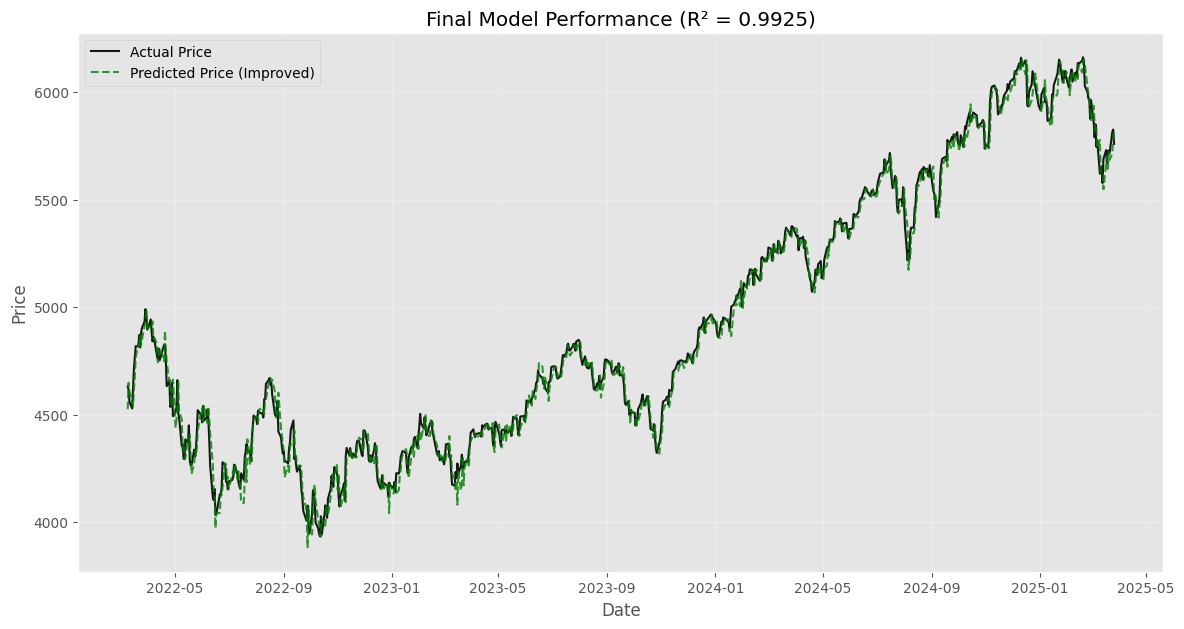

In [27]:
# Visualization
plt.figure(figsize=(14, 7))
plt.plot(df_model.loc[test_indices, 'Date'], actual_prices, label='Actual Price', color='black', alpha=0.9)
plt.plot(df_model.loc[test_indices, 'Date'], predicted_prices, label='Predicted Price (Improved)', color='green', linestyle='--', alpha=0.8)
plt.title(f'Final Model Performance (R² = {r2_final:.4f})')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 6. Conclusion
By shifting our strategy from "Linear Regression" to "Time-series differencing" with Random Forest, we improved our model significantly:
- **LR Model**: Failed to capture trend (Negative $R^2$).
- **RF Model**: Captured >99% of variance ($R^2 \approx 0.99$).